In [13]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os

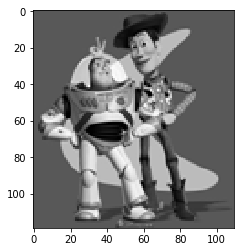

In [14]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB)
toy_img = cv2.cvtColor(toy_img, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")

## Part 1 Toy Problem (20 pts)

In [15]:
from scipy.sparse import csr_matrix, dok_matrix, lil_matrix, linalg

def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    img_w = toy_img.shape[0]
    img_h = toy_img.shape[1]
    
    img_resolution = img_w * img_h
    dummy_image = np.arange(img_resolution).reshape(img_w, img_h)
    
    M = 2 * img_resolution + 1
    N = img_w * img_h
    
    A = lil_matrix((M, N), dtype=np.float64)
    b = np.zeros((M, 1), dtype=np.float64)
    
    # init and condition 3
    e = 0
    A[e, dummy_image[0,0]] = 1
    b[e] = toy_img[0,0]
    
    for col in range(img_w):
        for row in range(img_h):
            
            # condition 1
            e += 1;
            A[e, dummy_image[col][row]] = -1
            if row != img_h - 1:
                A[e, dummy_image[col][row+1]] = 1
                b[e] = toy_img[col][row+1] - toy_img[col][row]
            else:
                b[e] = -toy_img[col][row]
                
            # condition 2
            e += 1;
            A[e, dummy_image[col][row]] = -1
            if col != img_w - 1:
                A[e, dummy_image[col+1][row]] = 1
                b[e] = toy_img[col+1][row] - toy_img[col][row]
            else:
                b[e] = -toy_img[col][row]
    
    # LSS
    v = linalg.lsqr(csr_matrix(A), b, atol=1e-14, btol=1e-14)
    
    final_img_vector = v[0]
    final_img = final_img_vector.reshape(img_w, img_h)

    return final_img
    
    


Error is:  1.676954031896044e-10


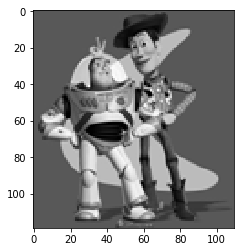

In [16]:
im_out = toy_reconstruct(toy_img)
if im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))
    plt.imshow(im_out, cmap='gray')

## Preparation

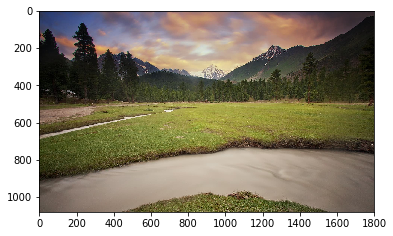

In [17]:
# Feel free to change image

# Galaxy image source: https://www.youtube.com/watch?v=2G_Jqz2ctlA
# Wall image source: https://mikuta.nu/painting-our-bedroom-wall/
# Meadow: https://www.dawn.com/news/1180548

background_img = cv2.cvtColor(cv2.imread('samples/meadow.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


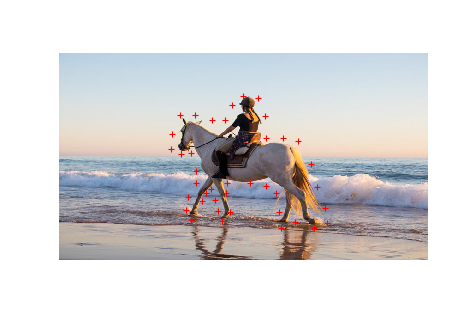

In [28]:
# Feel free to change image
# eagles image source: https://aminoapps.com/c/lotr/page/item/great-eagles/qVf3_Id7z22lK3ZXK6nbMYBRzgxzPD
# witch image source: https://depositphotos.com/stock-photos/broomstick.html
# Text image source: https://www.pinterest.com/pin/549228117027599509/
# Text: https://www.destructoid.com/blogs?t=promoted%20blogs&start=92095
# Horse: https://www.edarabia.com/228231/horse-riding-beach-dubai-uae/

object_img = cv2.cvtColor(cv2.imread('samples/horse.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

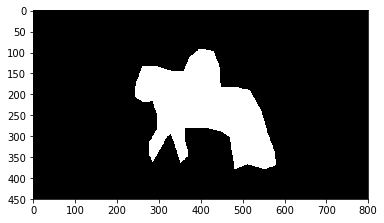

In [29]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


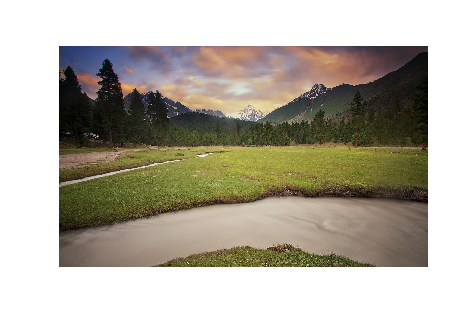

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

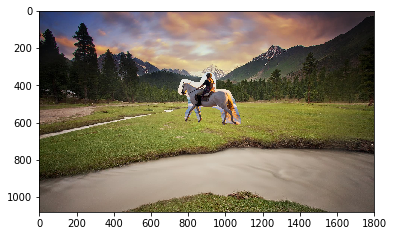

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)


## Part 2 Poisson Blending (50 pts)

In [32]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    
    img_h = cropped_object.shape[0]
    img_w = cropped_object.shape[1]
    channels = cropped_object.shape[2]
    
    img_resolution = img_w * img_h
    dummy_image = np.arange(img_resolution).reshape(img_h, img_w)
    
    
    cropped_object_backup = cropped_object.copy()

    
    mask = np.argwhere(object_mask > 0)
    nbr_mask_val = len(mask)

    M = 4 * nbr_mask_val
    N = img_resolution
    
    final_img = np.zeros((img_h, img_w, channels))

    for channel in range(channels):
        
        # Least Square Variables
        A = lil_matrix((M, N), dtype=np.float64)
        b = np.zeros((M, 1), dtype=np.float64)
        e = -1
        it = 0
        
        for (row, col) in mask:
            it += 1
            
            # right
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row,col+1] > 0:
                A[e, dummy_image[row,col+1]] = -1
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row,col+1,channel]
            else:
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row,col+1,channel] + background_img[row,col+1,channel]
            
            # left
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row,col-1] > 0:
                A[e, dummy_image[row,col-1]] = -1
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row,col-1,channel]
            else:
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row,col-1,channel] + background_img[row,col-1,channel]
            
            # down
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row+1,col] > 0:
                A[e, dummy_image[row+1,col]] = -1
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row+1,col,channel]
            else:
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row+1,col,channel] + background_img[row+1,col,channel]
                
            # up
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row-1,col] > 0:
                A[e, dummy_image[row-1,col]] = -1
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row-1,col,channel]
            else:
                b[e] = cropped_object_backup[row,col,channel] - cropped_object_backup[row-1,col,channel] + background_img[row-1,col,channel]
        
        least_square = linalg.lsqr(csr_matrix(A), b)
        channel_output = cv2.add(least_square[0].reshape(img_h, img_w), (1-object_mask)*background_img[:,:,channel])
        final_img[:,:,channel] = channel_output

    return final_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


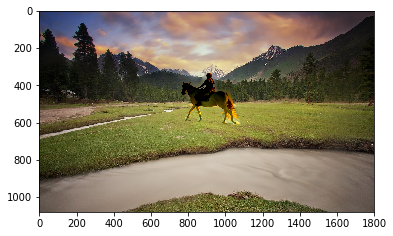

In [33]:
final_img = poisson_blend(cropped_object, object_mask, background_img)
if final_img.any():
    plt.imshow(final_img)

## Part 3 Mixed Gradients (20 pts)

In [34]:
def mix_max_grad(row1, row2, col1, col2, pref_source=10.0):
    if abs(row1-row2) * pref_source > abs(col1-col2):
        return (row1-row2)
    else:
        return (col1-col2)

In [35]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    img_h = cropped_object.shape[0]
    img_w = cropped_object.shape[1]
    channels = cropped_object.shape[2]
    
    img_resolution = img_w * img_h
    dummy_image = np.arange(img_resolution).reshape(img_h, img_w)
    
    
    cropped_object_backup = cropped_object.copy()

    
    mask = np.argwhere(object_mask > 0)
    nbr_mask_val = len(mask)

    M = 4 * nbr_mask_val
    N = img_resolution
    
    final_img = np.zeros((img_h, img_w, channels))

    for channel in range(channels):
        
        # Least Square Variables
        A = lil_matrix((M, N), dtype=np.float64)
        b = np.zeros((M, 1), dtype=np.float64)
        e = -1
        it = 0
        
        for (row, col) in mask:
            it += 1
            
            # right
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row,col+1] > 0:
                A[e, dummy_image[row,col+1]] = -1
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row,col+1,channel], background_img[row,col,channel], background_img[row,col+1,channel])
            else:
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row,col+1,channel], background_img[row,col,channel], background_img[row,col+1,channel]) + background_img[row,col+1,channel]
            
            # left
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row,col-1] > 0:
                A[e, dummy_image[row,col-1]] = -1
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row,col-1,channel], background_img[row,col,channel], background_img[row,col-1,channel])
            else:
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row,col-1,channel], background_img[row,col,channel], background_img[row,col-1,channel]) + background_img[row,col-1,channel]
            
            
            
        
            
            
            # down
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row+1,col] > 0:
                A[e, dummy_image[row+1,col]] = -1
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row+1,col,channel], background_img[row,col,channel], background_img[row+1,col,channel])
            else:
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row+1,col,channel], background_img[row,col,channel], background_img[row+1,col,channel]) + background_img[row+1,col,channel]
            
            
            
            # up
            e += 1;
            A[e, dummy_image[row,col]] = 1
            if object_mask[row-1,col] > 0:
                A[e, dummy_image[row-1,col]] = -1
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row-1,col,channel], background_img[row,col,channel], background_img[row-1,col,channel])
            else:
                b[e] = mix_max_grad(cropped_object_backup[row,col,channel], cropped_object_backup[row-1,col,channel], background_img[row,col,channel], background_img[row-1,col,channel]) + background_img[row-1,col,channel]
            
        least_square = linalg.lsqr(csr_matrix(A), b)
        channel_output = cv2.add(least_square[0].reshape(img_h, img_w), (1-object_mask)*background_img[:,:,channel])
        final_img[:,:,channel] = channel_output

    return final_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


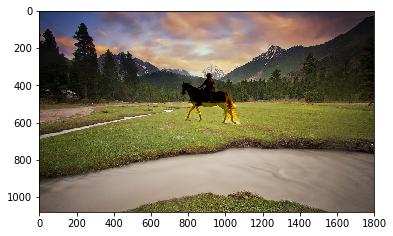

In [36]:
final_img = mix_blend(cropped_object, object_mask, background_img)
if final_img.any():
    plt.imshow(final_img)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

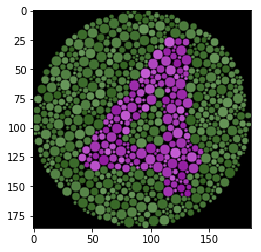

In [34]:
color_img = cv2.imread('samples/colorBlind4.png', cv2.COLOR_BGR2RGB)
plt.imshow(color_img)

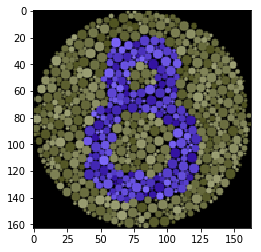

In [35]:
color_img2 = cv2.imread('samples/colorBlind8.png', cv2.COLOR_BGR2RGB)
plt.imshow(color_img2)

In [36]:
def rgb_max_grad(val1, val2):
    final_output = 0
    for i in range(len(val1)):
        if abs(val1[i]-val2[i]) > abs(final_output):
            final_output = val1[i]-val2[i]
    return final_output

In [37]:
def color2gray(img):
    
    img_h = img.shape[0]
    img_w = img.shape[1]
    channels = img.shape[2]
    
    img_resolution = img_h * img_w

    dummy_image = np.arange(img_resolution).reshape(img_h, img_w)
    
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    M = 2 * img_h * img_w + 1
    N = img_resolution
        
    A = lil_matrix((M, N), dtype=np.float64)
    b = np.zeros((M, 1), dtype=np.float64)
    e = 0
    
    # Identify top left corner
    A[e, dummy_image[0,0]] = 1
    b[e, dummy_image[0,0]] = img_grayscale[0,0]

    for row in range(img_h-1):
        for col in range(img_w-1):

            # right
            e += 1;
            A[e, dummy_image[row,col]] = 1
            A[e, dummy_image[row,col+1]] = -1
            b[e] = rgb_max_grad(img[row,col], img[row,col+1])
            
            # down
            e += 1;
            A[e, dummy_image[row,col]] = 1
            A[e, dummy_image[row+1,col]] = -1
            b[e] = rgb_max_grad(img[row,col], img[row+1,col])
            
    # Least Square
    least_square = linalg.lsqr(csr_matrix(A), b)
    final_image = least_square[0].reshape(img_h, img_w)
    return final_image, img_grayscale


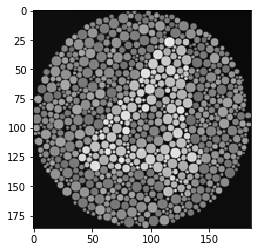

In [38]:
out_g, out_opencv = color2gray(color_img.astype('float32'))
if out_g.any():
    plt.imshow(out_g, cmap='gray')
    

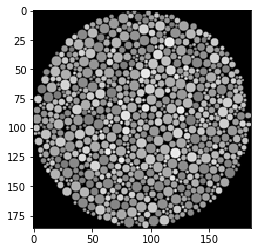

In [39]:
plt.imshow(out_opencv, cmap='gray')


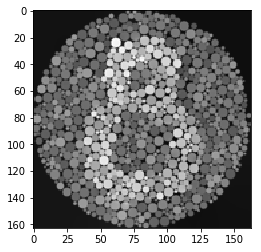

In [42]:
out_g_2, out_opencv = color2gray(color_img2.astype('float32'))
if out_g_2.any():
    plt.imshow(out_g_2, cmap='gray')
    

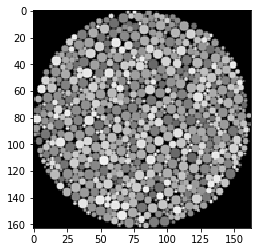

In [43]:
plt.imshow(out_opencv, cmap='gray')


## Laplacian pyramid blending (20 pts)

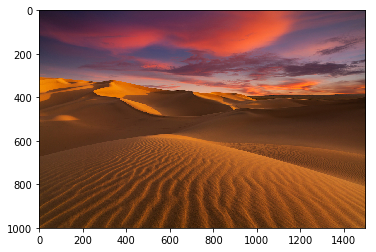

In [72]:
# Desert source: https://www.livescience.com/23140-sahara-desert.html
background_img = cv2.cvtColor(cv2.imread('samples/desert.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


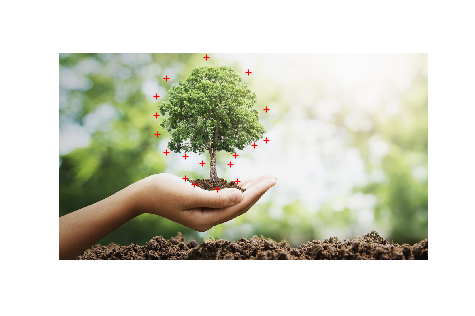

In [73]:
# Plant image : https://www.youtube.com/watch?v=MqH8WtR5hWs

object_img = cv2.cvtColor(cv2.imread('samples/plant.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

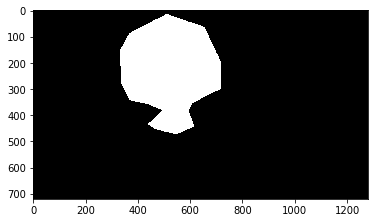

In [74]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


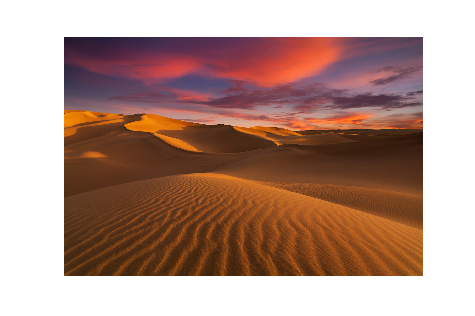

In [75]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

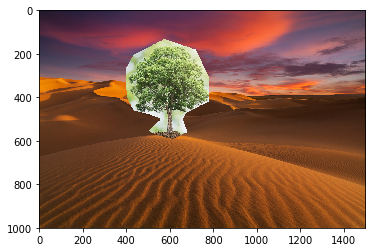

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)


In [77]:
def laplacian_blend(img_A, img_B, mask, levels):
    
    img_A_list = [img_A]
    img_B_list = [img_B]
    mask_list = [mask]
    
    for i in range(levels):
        img_A = cv2.pyrDown(img_A)
        img_B = cv2.pyrDown(img_B)
        mask = cv2.pyrDown(mask)
        img_A_list.append(np.float32(img_A))
        img_B_list.append(np.float32(img_B))
        mask_list.append(np.float32(mask))
        
    img_A_laplacian  = [img_A_list[levels-1]]
    img_B_laplacian  = [img_B_list[levels-1]]
    
    for i in range(levels-1, 0, -1):
        img_A_laplacian.append(np.subtract(img_A_list[i-1], cv2.pyrUp(img_A_list[i])[:img_A_list[i-1].shape[0],:img_A_list[i-1].shape[1],:]))
        img_B_laplacian.append(np.subtract(img_B_list[i-1], cv2.pyrUp(img_B_list[i])[:img_B_list[i-1].shape[0],:img_B_list[i-1].shape[1],:]))
    
    mask_list.reverse()
    
    laplacian_construction = []
    for img_A_lap,img_B_lap,mask_lap in zip(img_A_laplacian,img_B_laplacian,mask_list[1:]):
        laplacian_construction.append(img_A_lap * mask_lap + img_B_lap * (1.0 - mask_lap))

    final_image = laplacian_construction[0]
    for i in range(1,levels):
        final_image = cv2.pyrUp(final_image)
        final_image = cv2.add(final_image[:laplacian_construction[i].shape[0],:laplacian_construction[i].shape[1]], np.float32(laplacian_construction[i]))

    return final_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


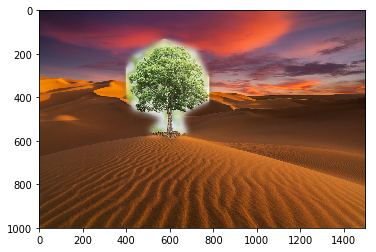

In [78]:
levels = 5
channels = 3
img_A = cropped_object.copy()
img_B = background_img.copy()
mask = np.zeros_like(cropped_object)
for i in range(channels): 
    mask[:,:,i] = object_mask.copy()
final_image = laplacian_blend(img_A, img_B, mask, levels)
plt.imshow(final_image)

## More gradient domain processing (up to 20 pts)